# Basic

In [1]:
import numpy as np
import pandas as pd
import itertools
import math, random, time, collections, pickle
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
sns.set_style("whitegrid")

# MCMC

In [2]:
M = np.zeros(shape=([28, 28]))
with open("data/letter_transition_matrix.csv", "r") as f:
    lines = f.readlines()
    assert len(lines)==28, "The size of the alphabet is 28"
    for i in range(28):
        M[i, :] = [float(x) for x in lines[i].split(",")]
logM = np.log(M) # 0 exists

P = np.zeros(shape=([28]))
with open("data/letter_probabilities.csv", "r") as f:
    line = f.readline()
    assert len(lines)==28, "The size of the alphabet is 28"
    P = [float(x) for x in line[:-1].split(",")]
logP = np.log(P)

with open("data/alphabet.csv", "r") as f:
    line = f.readline()
    assert len(lines)==28, "The size of the alphabet is 28"
    Alphabet = line[:-1].split(",")
    content2idx = {}
    idx2content = {}
    for i in range(28):
        content2idx[Alphabet[i]] = i
        idx2content[i] = Alphabet[i]

with open("test_ciphertext.txt", "r") as f:
    ciphertext = f.read()[:-1] # replace \n at the end of the file
with open("test_plaintext.txt", "r") as f:
    plaintext = f.read()[:-1] # replace \n at the end of the file

/home/shiyinw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [3]:
def checkvalid(content):
    transition = collections.Counter()
    for i in Alphabet:
        transition[i] = collections.Counter()
    for i in range(1, len(content), 1):  # including /n
        transition[content[i - 1]][content[i]] += 1

    notrepeat = []  # ' ' & '.'
    for a in Alphabet:
        if (transition[a][a] == 0):
            notrepeat.append(a)

    set1 = []  # " "
    set2 = []  # "."
    for a in notrepeat:
        if (len(transition[a]) == 0):
            set2.append(a)
        elif (len(transition[a]) == 1 and list(transition[a].keys())[0] in notrepeat):
            set1.append(list(transition[a].keys())[0])
            set2.append(a)

    if (len(transition) == 28):  # All the char have occurred. So we must have a ". " pair.
        return set2, set1
    else:
        return set2, notrepeat
    
class MCMC:
    def __init__(self, ciphertext, answer):
        self.alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.']
        alphabet = self.alphabet.copy()
        self.answer = answer
        self.idx2alpha = dict(zip(range(28), self.alphabet))
        random.shuffle(alphabet)
        self.cur_f = dict(zip(alphabet, range(28)))
        self.ciphertext_transition = collections.Counter()
        for a in self.alphabet:
            self.ciphertext_transition[a] = collections.Counter()
        for i in range(1, len(ciphertext), 1): #including /n
            self.ciphertext_transition[ciphertext[i]][ciphertext[i-1]] += 1
        self.ciphertext = ciphertext
        self.set1, self.set2 = checkvalid(self.ciphertext)
        
    def Pf(self, code2idx):
        logPf = logP[code2idx[self.ciphertext[0]]]
        for a in self.alphabet:
            for b in self.alphabet:
                if self.ciphertext_transition[a][b]!=0:
                    if logM[code2idx[a], code2idx[b]] == -math.inf:
                        return "not exist"
                    else:
                        logPf += self.ciphertext_transition[a][b] * logM[code2idx[a], code2idx[b]]
        
        return logPf
    
    def generate_f(self, oldf, set1, set2):
        # set1: "."
        # set2 : " "
        a, b = random.sample(self.alphabet, 2)
        f2 = oldf.copy()
        f2[a] = self.cur_f[b]
        f2[b] = self.cur_f[a]
        for i, v in f2.items():
            if (v == 27 and i not in set1):
                candidate = random.sample(self.set1, k=1)[0]
                tmp = f2[i]
                f2[i] = f2[candidate]
                f2[candidate] = tmp
            if (v == 26 and i not in set2):
                candidate = random.sample(self.set2, k=1)[0]
                tmp = f2[i]
                f2[i] = f2[candidate]
                f2[candidate] = tmp
        return f2

    
    def decode(self):
        s = ""
        for c in self.ciphertext:
            s += self.idx2alpha[self.cur_f[c]]
        return s
    
    def accuracy(self, answer):
        s = 0
        assert len(self.ciphertext)==len(answer), "answer length not align"
        for c in range(len(self.ciphertext)):
            if (self.idx2alpha[self.cur_f[self.ciphertext[c]]]==answer[c]):
                s += 1
#         print("Accuracy {}/{}".format(s, len(self.ciphertext)))
        return s
        
    
    def run(self, n=5000, printacc=True):
        start_time = time.time()
        loglikelihood = []
        times = []
        acc = []
        accepted = []
        for t in range(n):
            f2 = self.generate_f(self.cur_f, self.set1, self.set2)
            pf2 = self.Pf(f2)
            pf1 = self.Pf(self.cur_f)
            rand = random.random()

            if pf1=="not exist" and pf2=="not exist":
                if random.random()<0.5:
                    accepted.append(True)
                    self.cur_f= f2
                else:
                    accepted.append(False)
            elif pf1=="not exist":
                accepted.append(True)
                self.cur_f = f2
            elif pf2=="not exist":
                accepted.append(False)
                pass
            
            elif pf2-pf1>5:
                self.cur_f = f2
                accepted.append(True)
            
            elif rand<min(1, np.exp(pf2-pf1)):
                self.cur_f = f2
                accepted.append(True)
                
            else:
                accepted.append(False)
                
    
            if self.Pf(self.cur_f) != "not exist":
                times.append(t)
                loglikelihood.append(self.Pf(self.cur_f))
                acc.append(100.*self.accuracy(self.answer)/len(self.ciphertext))
            else:
                times.append(math.nan)
                loglikelihood.append(math.nan)
                acc.append(math.nan)
                
            if(np.sum(accepted[-1000:])==0):
                break
                
                
            if printacc:
                if (t%1000==0):
                    print("Accuracy {}/{}, Log-Liklihood {}, time {} ({}/{})".format(self.accuracy(self.answer), len(self.answer), self.Pf(self.cur_f), time.time()-start_time, t, n))
        return times, loglikelihood, acc, accepted

In [9]:
def run(seed):
    random.seed(time.time()*random.random())
    mcmc = MCMC(ciphertext=ciphertext, answer=plaintext)
    times, loglikelihood, acc, accepted = mcmc.run()
    return times, loglikelihood, acc, accepted

p = Pool(processes=100)
data = p.map(run, [random.random()*10000 for x in range(1000)])
p.close()

Accuracy 947/5287, Log-Liklihood not exist, time 0.02266693115234375 (0/5000)
Accuracy 1245/5287, Log-Liklihood not exist, time 0.012749671936035156 (0/5000)
Accuracy 134/5287, Log-Liklihood -31065.326637275986, time 0.038826704025268555 (0/5000)
Accuracy 250/5287, Log-Liklihood -43430.86899632821, time 0.018378019332885742 (0/5000)
Accuracy 997/5287, Log-Liklihood -27552.38687726958, time 0.07132959365844727 (0/5000)
Accuracy 1074/5287, Log-Liklihood -28128.954393130025, time 0.03300142288208008 (0/5000)
Accuracy 1341/5287, Log-Liklihood -27489.646714549363, time 0.03266263008117676 (0/5000)
Accuracy 62/5287, Log-Liklihood -33136.25327151286, time 0.018190860748291016 (0/5000)
Accuracy 397/5287, Log-Liklihood -29335.05638354451, time 0.020603418350219727 (0/5000)
Accuracy 0/5287, Log-Liklihood -37608.81074869628, time 0.027242422103881836 (0/5000)
Accuracy 993/5287, Log-Liklihood -24914.171233345056, time 0.010796546936035156 (0/5000)
Accuracy 46/5287, Log-Liklihood not exist, time 0.

Accuracy 0/5287, Log-Liklihood -39414.331508089854, time 0.06810784339904785 (0/5000)
Accuracy 1083/5287, Log-Liklihood -30057.37558005159, time 0.12776660919189453 (0/5000)
Accuracy 1553/5287, Log-Liklihood -26308.78092128119, time 0.06872105598449707 (0/5000)
Accuracy 357/5287, Log-Liklihood -32226.064848671464, time 0.06204533576965332 (0/5000)
Accuracy 5273/5287, Log-Liklihood -12616.18431531122, time 40.23432779312134 (1000/5000)
Accuracy 792/5287, Log-Liklihood -18038.892034586675, time 40.51547884941101 (1000/5000)
Accuracy 4329/5287, Log-Liklihood -13486.31076838043, time 40.738752365112305 (1000/5000)
Accuracy 2642/5287, Log-Liklihood -15355.450165099193, time 40.643237829208374 (1000/5000)
Accuracy 1461/5287, Log-Liklihood -17223.18867626638, time 40.88790965080261 (1000/5000)
Accuracy 5278/5287, Log-Liklihood -12580.948407861222, time 40.94592523574829 (1000/5000)
Accuracy 2548/5287, Log-Liklihood -17600.748748450376, time 41.0525906085968 (1000/5000)
Accuracy 4635/5287, Log

Accuracy 4336/5287, Log-Liklihood -13842.581157632123, time 46.2055459022522 (1000/5000)
Accuracy 3237/5287, Log-Liklihood -15559.578564022135, time 46.25823473930359 (1000/5000)
Accuracy 5099/5287, Log-Liklihood -12962.11059766661, time 46.32773232460022 (1000/5000)
Accuracy 4598/5287, Log-Liklihood -13204.40758644886, time 46.335076570510864 (1000/5000)
Accuracy 4630/5287, Log-Liklihood -13537.298914286708, time 46.283594846725464 (1000/5000)
Accuracy 4348/5287, Log-Liklihood -14421.381736575182, time 46.4261794090271 (1000/5000)
Accuracy 1298/5287, Log-Liklihood -18291.332225532926, time 46.57883310317993 (1000/5000)
Accuracy 4957/5287, Log-Liklihood -13499.954960705758, time 46.680476903915405 (1000/5000)
Accuracy 4446/5287, Log-Liklihood -13340.254666374853, time 46.992706537246704 (1000/5000)
Accuracy 4867/5287, Log-Liklihood -13099.37340316428, time 47.20002627372742 (1000/5000)
Accuracy 4657/5287, Log-Liklihood -14386.760990464236, time 47.14204955101013 (1000/5000)
Accuracy 44

Accuracy 5139/5287, Log-Liklihood -13007.66816433559, time 90.69726467132568 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 90.95256280899048 (2000/5000)
Accuracy 5273/5287, Log-Liklihood -12616.18431531122, time 91.2115273475647 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 91.24439597129822 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 91.2461154460907 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 91.5686023235321 (2000/5000)
Accuracy 5278/5287, Log-Liklihood -12580.948407861222, time 91.72612953186035 (2000/5000)
Accuracy 4862/5287, Log-Liklihood -12828.864966996473, time 91.84985017776489 (2000/5000)
Accuracy 4908/5287, Log-Liklihood -13369.225073378084, time 91.83970975875854 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 91.91222524642944 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 91.92329740524292 (2000/5000)
Accuracy 5282/5

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 134.58500957489014 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 134.67774987220764 (3000/5000)
Accuracy 5278/5287, Log-Liklihood -12580.948407861222, time 134.71131873130798 (3000/5000)
Accuracy 5287/5287, Log-Liklihood -12559.858844529925, time 134.73033690452576 (3000/5000)
Accuracy 4598/5287, Log-Liklihood -13204.40758644886, time 134.95776057243347 (3000/5000)
Accuracy 3958/5287, Log-Liklihood -14846.632719269417, time 135.02111387252808 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 135.15271091461182 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 135.15454769134521 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 135.17659091949463 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 135.33072328567505 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 135.72706174850464 (3000/5000)


Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 176.98930263519287 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.06048345565796 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.1526689529419 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.27267622947693 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.61747455596924 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.7294795513153 (4000/5000)
Accuracy 4862/5287, Log-Liklihood -12828.864966996473, time 177.75022077560425 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.86121201515198 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.9374942779541 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.98937606811523 (4000/5000)
Accuracy 2033/5287, Log-Liklihood -16433.01418407484, time 178.1527497768402 (4000/5000)
Accu

Accuracy 1071/5287, Log-Liklihood -26400.81096286844, time 0.05329465866088867 (0/5000)
Accuracy 317/5287, Log-Liklihood -34752.4473582819, time 0.05769801139831543 (0/5000)
Accuracy 1055/5287, Log-Liklihood -29950.213976427884, time 0.02909255027770996 (0/5000)
Accuracy 1271/5287, Log-Liklihood -30272.461675404462, time 0.06487584114074707 (0/5000)
Accuracy 947/5287, Log-Liklihood -25181.67205543533, time 0.04804587364196777 (0/5000)
Accuracy 0/5287, Log-Liklihood -40044.26546481379, time 0.08728528022766113 (0/5000)
Accuracy 0/5287, Log-Liklihood -33627.70194390221, time 0.06283020973205566 (0/5000)
Accuracy 947/5287, Log-Liklihood -31720.90643867184, time 0.06122112274169922 (0/5000)
Accuracy 1083/5287, Log-Liklihood -26797.324717657055, time 0.010856151580810547 (0/5000)
Accuracy 993/5287, Log-Liklihood -27293.858351572715, time 0.05850934982299805 (0/5000)
Accuracy 0/5287, Log-Liklihood -38405.30134042096, time 0.036655426025390625 (0/5000)
Accuracy 993/5287, Log-Liklihood -36054.

Accuracy 4074/5287, Log-Liklihood -14721.205105886942, time 45.2511260509491 (1000/5000)
Accuracy 3243/5287, Log-Liklihood -15055.516546127456, time 44.053263902664185 (1000/5000)
Accuracy 4305/5287, Log-Liklihood -13907.40239549646, time 43.355647802352905 (1000/5000)
Accuracy 4454/5287, Log-Liklihood -13291.782772876126, time 44.159430265426636 (1000/5000)
Accuracy 321/5287, Log-Liklihood -18705.944903438412, time 43.4874267578125 (1000/5000)
Accuracy 2793/5287, Log-Liklihood -15240.721376321755, time 43.47829604148865 (1000/5000)
Accuracy 3650/5287, Log-Liklihood -15022.559168413021, time 44.11579775810242 (1000/5000)
Accuracy 4509/5287, Log-Liklihood -13371.510404563469, time 44.77785515785217 (1000/5000)
Accuracy 1455/5287, Log-Liklihood -17872.838614188626, time 44.99079132080078 (1000/5000)
Accuracy 4382/5287, Log-Liklihood -14274.768975490522, time 44.30301260948181 (1000/5000)
Accuracy 3975/5287, Log-Liklihood -14828.767043485677, time 43.459736347198486 (1000/5000)
Accuracy 2

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 86.66902780532837 (2000/5000)
Accuracy 1122/5287, Log-Liklihood -18410.061222763914, time 86.07042694091797 (2000/5000)
Accuracy 2894/5287, Log-Liklihood -17712.363419388515, time 88.39889001846313 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 88.05343627929688 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 87.38302779197693 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 87.37641191482544 (2000/5000)
Accuracy 321/5287, Log-Liklihood -18460.911463528795, time 86.52743911743164 (2000/5000)
Accuracy 5144/5287, Log-Liklihood -12787.653946945991, time 85.59503936767578 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 90.23079371452332 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 87.47010707855225 (2000/5000)
Accuracy 5108/5287, Log-Liklihood -12689.596357473, time 89.21968150138855 (2000/5000)
Accuracy 5082/

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 126.91422080993652 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 128.57975149154663 (3000/5000)
Accuracy 2239/5287, Log-Liklihood -16406.737134232193, time 124.15006637573242 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 128.59429168701172 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 127.39291429519653 (3000/5000)
Accuracy 3906/5287, Log-Liklihood -15089.058982574381, time 127.86452603340149 (3000/5000)
Accuracy 1122/5287, Log-Liklihood -18410.061222763914, time 128.59608483314514 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 128.43375205993652 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 130.0181941986084 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 129.99800825119019 (3000/5000)
Accuracy 2254/5287, Log-Liklihood -16416.427255555245, time 129.9583888053894 (3000/5000)
A

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 168.98108625411987 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 170.61033248901367 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 171.68747687339783 (4000/5000)
Accuracy 2828/5287, Log-Liklihood -16922.220539174352, time 167.93996286392212 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 170.58899545669556 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 173.94601678848267 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 169.66670727729797 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 165.68162393569946 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 168.88571786880493 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 174.47291254997253 (4000/5000)
Accuracy 711/5287, Log-Liklihood -18216.72269647234, time 166.8717029094696 (4000/5000)
Ac

Accuracy 0/5287, Log-Liklihood -26370.560183128477, time 0.027742385864257812 (0/5000)
Accuracy 0/5287, Log-Liklihood -38823.58566187993, time 0.05443596839904785 (0/5000)
Accuracy 67/5287, Log-Liklihood -32317.243094119953, time 0.027933359146118164 (0/5000)
Accuracy 93/5287, Log-Liklihood -29441.22538841154, time 0.009967565536499023 (0/5000)
Accuracy 947/5287, Log-Liklihood -26576.457407895403, time 0.07344412803649902 (0/5000)
Accuracy 46/5287, Log-Liklihood not exist, time 0.0389406681060791 (0/5000)
Accuracy 1028/5287, Log-Liklihood -23436.474888149263, time 0.05839204788208008 (0/5000)
Accuracy 0/5287, Log-Liklihood -32451.169943582652, time 0.0694434642791748 (0/5000)
Accuracy 993/5287, Log-Liklihood -27252.611043634406, time 0.053518056869506836 (0/5000)
Accuracy 947/5287, Log-Liklihood -30728.408314830493, time 0.08300042152404785 (0/5000)
Accuracy 0/5287, Log-Liklihood -35026.3185945394, time 0.03778219223022461 (0/5000)
Accuracy 1356/5287, Log-Liklihood -28108.92259917116, 

Accuracy 167/5287, Log-Liklihood -18191.65103113596, time 40.03800988197327 (1000/5000)
Accuracy 3401/5287, Log-Liklihood -15046.329288633999, time 43.44059491157532 (1000/5000)
Accuracy 947/5287, Log-Liklihood -26879.956497304298, time 0.03211665153503418 (0/5000)
Accuracy 4925/5287, Log-Liklihood -13007.273770969567, time 42.481499910354614 (1000/5000)
Accuracy 1551/5287, Log-Liklihood -17077.79817028481, time 39.61522388458252 (1000/5000)
Accuracy 796/5287, Log-Liklihood -18921.40096851008, time 43.3011040687561 (1000/5000)
Accuracy 1437/5287, Log-Liklihood -18328.5499662262, time 41.39044976234436 (1000/5000)
Accuracy 3151/5287, Log-Liklihood -15612.207482881762, time 43.769789934158325 (1000/5000)
Accuracy 4846/5287, Log-Liklihood -13548.613660917066, time 42.941571950912476 (1000/5000)
Accuracy 2505/5287, Log-Liklihood -15802.229864788704, time 42.18678569793701 (1000/5000)
Accuracy 2960/5287, Log-Liklihood -15639.488832360845, time 41.584776639938354 (1000/5000)
Accuracy 1199/52

Accuracy 4432/5287, Log-Liklihood -14159.297789420449, time 46.4675977230072 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 82.76835918426514 (2000/5000)
Accuracy 1333/5287, Log-Liklihood -17959.08650076451, time 82.83148431777954 (2000/5000)
Accuracy 4372/5287, Log-Liklihood -14456.933363160077, time 45.21295928955078 (1000/5000)
Accuracy 3575/5287, Log-Liklihood -14603.296999680253, time 82.60182738304138 (2000/5000)
Accuracy 4042/5287, Log-Liklihood -14668.282372809388, time 46.78402090072632 (1000/5000)
Accuracy 3075/5287, Log-Liklihood -14831.0480627615, time 46.09575915336609 (1000/5000)
Accuracy 3888/5287, Log-Liklihood -14443.176751357345, time 46.08058261871338 (1000/5000)
Accuracy 4866/5287, Log-Liklihood -13256.825837387598, time 47.698742628097534 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 82.89814782142639 (2000/5000)
Accuracy 1483/5287, Log-Liklihood -17573.350047385957, time 83.93280029296875 (2000/5000)
Accuracy 3045

Accuracy 1322/5287, Log-Liklihood -17406.480735451245, time 89.61474800109863 (2000/5000)
Accuracy 5287/5287, Log-Liklihood -12559.858844529925, time 89.44793629646301 (2000/5000)
Accuracy 3050/5287, Log-Liklihood -16929.552738298753, time 124.89974617958069 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 89.07112383842468 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 89.91106820106506 (2000/5000)
Accuracy 2422/5287, Log-Liklihood -17041.283247707972, time 90.28652954101562 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 126.53066635131836 (3000/5000)
Accuracy 4652/5287, Log-Liklihood -13042.503456486398, time 90.45374321937561 (2000/5000)
Accuracy 5188/5287, Log-Liklihood -12800.250999421505, time 89.75770664215088 (2000/5000)
Accuracy 2425/5287, Log-Liklihood -16879.21984996569, time 89.70569920539856 (2000/5000)
Accuracy 2548/5287, Log-Liklihood -17081.637721119736, time 91.38585638999939 (2000/5000)
Accuracy 

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 162.91795420646667 (4000/5000)
Accuracy 4388/5287, Log-Liklihood -13917.65750771917, time 166.02613854408264 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 133.96834516525269 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 169.4797763824463 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 135.45685982704163 (3000/5000)
Accuracy 598/5287, Log-Liklihood -18915.62746152061, time 133.40164303779602 (3000/5000)
Accuracy 2328/5287, Log-Liklihood -16233.235362643554, time 132.11420726776123 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 136.77686309814453 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 168.50798225402832 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 137.87504196166992 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 133.08146953582764 (3000/5000)
Acc

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 178.57146739959717 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.0175154209137 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.10361576080322 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.29046320915222 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 178.71424317359924 (4000/5000)
Accuracy 947/5287, Log-Liklihood not exist, time 0.0045108795166015625 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 171.0102264881134 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 174.97861909866333 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 176.22558975219727 (4000/5000)
Accuracy 844/5287, Log-Liklihood -18368.319977860137, time 175.00098514556885 (4000/5000)
Accuracy 1225/5287, Log-Liklihood -28450.60020611568, time 0.10237932205200195 (0/5000)
Accuracy 5282/52

Accuracy 808/5287, Log-Liklihood -37614.189832248245, time 0.05440378189086914 (0/5000)
Accuracy 4553/5287, Log-Liklihood -14010.337428412224, time 40.61733078956604 (1000/5000)
Accuracy 3854/5287, Log-Liklihood -14267.59273721712, time 43.57021474838257 (1000/5000)
Accuracy 0/5287, Log-Liklihood -32677.927177487887, time 0.011108636856079102 (0/5000)
Accuracy 947/5287, Log-Liklihood -28554.621217617794, time 0.07621240615844727 (0/5000)
Accuracy 46/5287, Log-Liklihood not exist, time 0.007944107055664062 (0/5000)
Accuracy 3383/5287, Log-Liklihood -15759.61827193814, time 42.46307110786438 (1000/5000)
Accuracy 947/5287, Log-Liklihood -28187.859198934693, time 0.0520021915435791 (0/5000)
Accuracy 0/5287, Log-Liklihood -29410.764517224816, time 0.04566311836242676 (0/5000)
Accuracy 4291/5287, Log-Liklihood -14014.22703264819, time 41.57187819480896 (1000/5000)
Accuracy 67/5287, Log-Liklihood -32711.39105825726, time 0.022976160049438477 (0/5000)
Accuracy 73/5287, Log-Liklihood not exist,

Accuracy 1365/5287, Log-Liklihood -16593.27355987574, time 44.83806777000427 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 85.9607412815094 (2000/5000)
Accuracy 4029/5287, Log-Liklihood -14239.795493332973, time 41.98545265197754 (1000/5000)
Accuracy 2951/5287, Log-Liklihood -14972.83134927038, time 45.226452350616455 (1000/5000)
Accuracy 5000/5287, Log-Liklihood -12964.81567246444, time 45.241745948791504 (1000/5000)
Accuracy 1110/5287, Log-Liklihood -17720.51092800956, time 42.80096244812012 (1000/5000)
Accuracy 4550/5287, Log-Liklihood -13144.801932661165, time 82.17120504379272 (2000/5000)
Accuracy 2135/5287, Log-Liklihood -16795.638308869886, time 41.284555435180664 (1000/5000)
Accuracy 3958/5287, Log-Liklihood -14846.632719269417, time 84.92656326293945 (2000/5000)
Accuracy 2478/5287, Log-Liklihood -15581.081728494619, time 45.05556058883667 (1000/5000)
Accuracy 5111/5287, Log-Liklihood -12768.868832931623, time 43.48227024078369 (1000/5000)
Accuracy 378

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 85.58822870254517 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 126.12825965881348 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 124.5512752532959 (3000/5000)
Accuracy 1787/5287, Log-Liklihood -16625.75344280124, time 125.3090009689331 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 87.4027931690216 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 86.71577525138855 (2000/5000)
Accuracy 4862/5287, Log-Liklihood -12828.864966996473, time 88.14679765701294 (2000/5000)
Accuracy 4196/5287, Log-Liklihood -14627.52547016229, time 83.35616564750671 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 88.46964144706726 (2000/5000)
Accuracy 5287/5287, Log-Liklihood -12559.858844529925, time 84.13340878486633 (2000/5000)
Accuracy 1463/5287, Log-Liklihood -16492.68513808954, time 87.7105016708374 (2000/5000)
Accuracy 5014/

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 133.6911380290985 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 132.62130045890808 (3000/5000)
Accuracy 998/5287, Log-Liklihood -16980.121667942192, time 154.8275818824768 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 160.8325698375702 (4000/5000)
Accuracy 1250/5287, Log-Liklihood -17513.147583104386, time 129.97229051589966 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 164.6771023273468 (4000/5000)
Accuracy 1787/5287, Log-Liklihood -16625.75344280124, time 165.50155663490295 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 167.12495636940002 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 132.173086643219 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 129.22638058662415 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 133.76688766479492 (3000/5000)
Accurac

Accuracy 0/5287, Log-Liklihood -36119.46537260781, time 0.04946184158325195 (0/5000)
Accuracy 0/5287, Log-Liklihood -32482.955912449685, time 0.0633246898651123 (0/5000)
Accuracy 927/5287, Log-Liklihood -17684.186793242836, time 173.1823387145996 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 169.54445266723633 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 177.01326823234558 (4000/5000)
Accuracy 1060/5287, Log-Liklihood -30369.096059695723, time 0.06513333320617676 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 171.60128211975098 (4000/5000)
Accuracy 0/5287, Log-Liklihood -32261.37425605036, time 0.12131309509277344 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 172.89524149894714 (4000/5000)
Accuracy 27/5287, Log-Liklihood -36114.612076652906, time 0.056220293045043945 (0/5000)
Accuracy 1060/5287, Log-Liklihood -30612.032500539615, time 0.010823488235473633 (0/5000)
Accuracy 3442/5287, Log-L

Accuracy 993/5287, Log-Liklihood -30447.174626476524, time 0.06669926643371582 (0/5000)
Accuracy 993/5287, Log-Liklihood -32245.764778401946, time 0.09196066856384277 (0/5000)
Accuracy 4108/5287, Log-Liklihood -13857.149643603292, time 37.38355994224548 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 182.03692317008972 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 180.19086718559265 (4000/5000)
Accuracy 357/5287, Log-Liklihood not exist, time 0.030482769012451172 (0/5000)
Accuracy 5036/5287, Log-Liklihood -13009.653383339766, time 41.865309715270996 (1000/5000)
Accuracy 4146/5287, Log-Liklihood -14821.4660566802, time 39.01052260398865 (1000/5000)
Accuracy 3778/5287, Log-Liklihood -15316.535571168146, time 41.64934706687927 (1000/5000)
Accuracy 46/5287, Log-Liklihood not exist, time 0.006215810775756836 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 180.361266374588 (4000/5000)
Accuracy 0/5287, Log-Liklihood -18622

Accuracy 3816/5287, Log-Liklihood -13941.394853328318, time 44.4317364692688 (1000/5000)
Accuracy 1055/5287, Log-Liklihood -32381.145191749176, time 0.0563201904296875 (0/5000)
Accuracy 947/5287, Log-Liklihood -32959.858084811414, time 0.04222416877746582 (0/5000)
Accuracy 4768/5287, Log-Liklihood -13434.08431114211, time 41.87950658798218 (1000/5000)
Accuracy 884/5287, Log-Liklihood -31362.605922057952, time 0.031150341033935547 (0/5000)
Accuracy 5174/5287, Log-Liklihood -12927.253188650027, time 76.85240769386292 (2000/5000)
Accuracy 4706/5287, Log-Liklihood -13608.538302859608, time 43.71337938308716 (1000/5000)
Accuracy 559/5287, Log-Liklihood -19011.17034449606, time 77.83550214767456 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 80.44747567176819 (2000/5000)
Accuracy 1023/5287, Log-Liklihood -31276.052072933588, time 0.09275054931640625 (0/5000)
Accuracy 0/5287, Log-Liklihood -35936.23952788588, time 0.03556108474731445 (0/5000)
Accuracy 4445/5287, Log-L

Accuracy 4477/5287, Log-Liklihood -14332.456872568091, time 45.6278350353241 (1000/5000)
Accuracy 3304/5287, Log-Liklihood -15258.472755661121, time 46.04232478141785 (1000/5000)
Accuracy 2941/5287, Log-Liklihood -15561.95389682444, time 45.05065703392029 (1000/5000)
Accuracy 1556/5287, Log-Liklihood -16827.322039640003, time 116.790452003479 (3000/5000)
Accuracy 4339/5287, Log-Liklihood -13550.134256587378, time 45.545149087905884 (1000/5000)
Accuracy 5036/5287, Log-Liklihood -12913.531200059277, time 83.86174511909485 (2000/5000)
Accuracy 4546/5287, Log-Liklihood -13568.67534190824, time 47.65443301200867 (1000/5000)
Accuracy 4311/5287, Log-Liklihood -14570.05268892442, time 45.018593549728394 (1000/5000)
Accuracy 4736/5287, Log-Liklihood -13392.313780941437, time 44.24168634414673 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 117.56344985961914 (3000/5000)
Accuracy 5121/5287, Log-Liklihood -12757.424345664274, time 48.110126972198486 (1000/5000)
Accuracy 46

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 130.42495775222778 (3000/5000)
Accuracy 4602/5287, Log-Liklihood -12972.644600896194, time 89.70654940605164 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 130.7160449028015 (3000/5000)
Accuracy 4839/5287, Log-Liklihood -13006.152442124934, time 89.77776837348938 (2000/5000)
Accuracy 4917/5287, Log-Liklihood -13525.916139363186, time 90.15352249145508 (2000/5000)
Accuracy 5036/5287, Log-Liklihood -12913.531200059277, time 91.34137344360352 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 128.9515974521637 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 129.78247475624084 (3000/5000)
Accuracy 2274/5287, Log-Liklihood -16425.85317046493, time 89.88933658599854 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 85.88679885864258 (2000/5000)
Accuracy 4108/5287, Log-Liklihood -14296.385308987792, time 89.45418787002563 (2000/5000)
Accuracy 

Accuracy 51/5287, Log-Liklihood not exist, time 0.03818321228027344 (0/5000)
Accuracy 1609/5287, Log-Liklihood -30292.931319884046, time 0.028593063354492188 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 130.45538306236267 (3000/5000)
Accuracy 1021/5287, Log-Liklihood -27398.924806006125, time 0.03470897674560547 (0/5000)
Accuracy 247/5287, Log-Liklihood -28989.804985331568, time 0.04319167137145996 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 170.46421885490417 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 172.96723914146423 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 170.80394864082336 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 137.32936549186707 (3000/5000)
Accuracy 5277/5287, Log-Liklihood -12611.004572516702, time 133.78662610054016 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 132.42054271697998 (3000/5000)
Accuracy 5282/5287,

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 176.70196270942688 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 175.7918312549591 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 174.07750272750854 (4000/5000)
Accuracy 1219/5287, Log-Liklihood -18379.499534078583, time 172.9566433429718 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 172.5234715938568 (4000/5000)
Accuracy 2898/5287, Log-Liklihood -16824.222474637238, time 171.32623386383057 (4000/5000)
Accuracy 0/5287, Log-Liklihood -38652.12302537526, time 0.1071169376373291 (0/5000)
Accuracy 3881/5287, Log-Liklihood -14674.285400801291, time 38.198795318603516 (1000/5000)
Accuracy 3654/5287, Log-Liklihood -13831.433460287919, time 41.003095388412476 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 173.2304630279541 (4000/5000)
Accuracy 4489/5287, Log-Liklihood -13787.450204952664, time 41.03790736198425 (1000/5000)
Accuracy 11

Accuracy 4405/5287, Log-Liklihood -13502.328247066289, time 38.17964434623718 (1000/5000)
Accuracy 4572/5287, Log-Liklihood -14192.59171635451, time 39.6660418510437 (1000/5000)
Accuracy 278/5287, Log-Liklihood -30674.787491283514, time 0.03243279457092285 (0/5000)
Accuracy 0/5287, Log-Liklihood -35505.29184014564, time 0.06266236305236816 (0/5000)
Accuracy 663/5287, Log-Liklihood -26478.661696995387, time 0.010778427124023438 (0/5000)
Accuracy 1072/5287, Log-Liklihood -31941.81160562799, time 0.03458523750305176 (0/5000)
Accuracy 4542/5287, Log-Liklihood -13636.024091513016, time 72.8808913230896 (2000/5000)
Accuracy 1071/5287, Log-Liklihood -27324.449931581257, time 0.051785945892333984 (0/5000)
Accuracy 403/5287, Log-Liklihood not exist, time 0.02619314193725586 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 75.69280576705933 (2000/5000)
Accuracy 947/5287, Log-Liklihood -33986.07144911911, time 0.026440143585205078 (0/5000)
Accuracy 98/5287, Log-Liklihood -3059

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 69.27820086479187 (2000/5000)
Accuracy 5287/5287, Log-Liklihood -12559.858844529925, time 71.94344472885132 (2000/5000)
Accuracy 4384/5287, Log-Liklihood -13773.1635355971, time 33.49692225456238 (1000/5000)
Accuracy 3076/5287, Log-Liklihood -15851.96914456169, time 35.448160886764526 (1000/5000)
Accuracy 3044/5287, Log-Liklihood -16493.933216212416, time 33.81687927246094 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 102.3761875629425 (3000/5000)
Accuracy 3570/5287, Log-Liklihood -15483.593293135555, time 35.678202867507935 (1000/5000)
Accuracy 4499/5287, Log-Liklihood -13239.565854045508, time 35.95386743545532 (1000/5000)
Accuracy 4638/5287, Log-Liklihood -13093.805511864382, time 33.9174382686615 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 106.36684083938599 (3000/5000)
Accuracy 3246/5287, Log-Liklihood -15634.57700819689, time 36.687334060668945 (1000/5000)
Accuracy 52

Accuracy 5113/5287, Log-Liklihood -12916.353105049833, time 70.33775472640991 (2000/5000)
Accuracy 1182/5287, Log-Liklihood -18493.2679033311, time 63.97052073478699 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 106.6128396987915 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 131.51704096794128 (4000/5000)
Accuracy 5014/5287, Log-Liklihood -13000.145910229969, time 70.73623871803284 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 106.08433794975281 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 68.11164331436157 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 69.79097890853882 (2000/5000)
Accuracy 4514/5287, Log-Liklihood -13375.484719845219, time 71.71991658210754 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 102.85466480255127 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 66.23771595954895 (2000/5000)
Accuracy 

Accuracy 4278/5287, Log-Liklihood -15010.02135537804, time 139.509774684906 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 69.54722619056702 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 100.26198482513428 (3000/5000)
Accuracy 5130/5287, Log-Liklihood -12717.976262016493, time 104.73012137413025 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 102.11461043357849 (3000/5000)
Accuracy 1649/5287, Log-Liklihood -16735.737329587162, time 103.4061005115509 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 102.41283917427063 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 100.2095787525177 (3000/5000)
Accuracy 1182/5287, Log-Liklihood -18493.2679033311, time 95.88590216636658 (3000/5000)
Accuracy 139/5287, Log-Liklihood not exist, time 0.03757643699645996 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 104.76297450065613 (3000/5000)
Accuracy 5282/5287, L

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 137.1855912208557 (4000/5000)
Accuracy 5069/5287, Log-Liklihood -13436.256106988705, time 104.95735788345337 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 105.01143455505371 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 101.13096117973328 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 101.06614255905151 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 104.5405330657959 (3000/5000)
Accuracy 0/5287, Log-Liklihood -29899.860741763623, time 0.14405584335327148 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 136.32852220535278 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 131.90783381462097 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 101.7844934463501 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 133.16713786125183 (4000/5000)
Accurac

Accuracy 357/5287, Log-Liklihood -32304.477302012, time 0.03455162048339844 (0/5000)
Accuracy 4232/5287, Log-Liklihood -13874.78969785585, time 31.594576120376587 (1000/5000)
Accuracy 1695/5287, Log-Liklihood -17482.452371257736, time 131.03253960609436 (4000/5000)
Accuracy 3587/5287, Log-Liklihood -14958.832302935567, time 30.634853839874268 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 132.7515983581543 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 128.98976755142212 (4000/5000)
Accuracy 947/5287, Log-Liklihood not exist, time 0.03250837326049805 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 132.13983726501465 (4000/5000)
Accuracy 1588/5287, Log-Liklihood -23275.74531757694, time 0.02893662452697754 (0/5000)
Accuracy 363/5287, Log-Liklihood -35689.79151102481, time 0.010575294494628906 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 133.92444133758545 (4000/5000)
Accuracy 5282/5287, Log-Li

Accuracy 1910/5287, Log-Liklihood -16053.083562917933, time 56.194995403289795 (2000/5000)
Accuracy 5011/5287, Log-Liklihood -13071.79316647879, time 28.883623361587524 (1000/5000)
Accuracy 4258/5287, Log-Liklihood -13511.677512543904, time 29.164963006973267 (1000/5000)
Accuracy 348/5287, Log-Liklihood -40238.74968387675, time 0.05655026435852051 (0/5000)
Accuracy 323/5287, Log-Liklihood -28543.032292618947, time 0.018270015716552734 (0/5000)
Accuracy 443/5287, Log-Liklihood not exist, time 0.006254673004150391 (0/5000)
Accuracy 46/5287, Log-Liklihood not exist, time 0.010313987731933594 (0/5000)
Accuracy 3647/5287, Log-Liklihood -14341.254754740963, time 26.763241291046143 (1000/5000)
Accuracy 0/5287, Log-Liklihood -32966.54825891533, time 0.027841806411743164 (0/5000)
Accuracy 2255/5287, Log-Liklihood -16441.495003902433, time 28.308806896209717 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 57.68779134750366 (2000/5000)
Accuracy 3838/5287, Log-Liklihood -14

Accuracy 4977/5287, Log-Liklihood -13106.446265156012, time 24.982460021972656 (1000/5000)
Accuracy 4758/5287, Log-Liklihood -13330.768059611459, time 22.691176176071167 (1000/5000)
Accuracy 3614/5287, Log-Liklihood -15557.035911714447, time 27.043529748916626 (1000/5000)
Accuracy 3008/5287, Log-Liklihood -15267.866085123353, time 27.909852743148804 (1000/5000)
Accuracy 2248/5287, Log-Liklihood -16461.745799925728, time 21.628358602523804 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 81.41524243354797 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 51.886563301086426 (2000/5000)
Accuracy 3878/5287, Log-Liklihood -14463.437210030426, time 23.478418350219727 (1000/5000)
Accuracy 2687/5287, Log-Liklihood -15637.011898372357, time 81.4300971031189 (3000/5000)
Accuracy 2924/5287, Log-Liklihood -16624.16273009199, time 53.87728238105774 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 114.05629515647888 (4000/5000)
Accu

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 54.55370593070984 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 57.61445498466492 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 48.58484172821045 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 108.33424210548401 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 114.47657871246338 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 107.55677342414856 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 81.6042275428772 (3000/5000)
Accuracy 4449/5287, Log-Liklihood -13267.823984972083, time 51.746848344802856 (2000/5000)
Accuracy 5287/5287, Log-Liklihood -12559.858844529925, time 43.83484745025635 (2000/5000)
Accuracy 4937/5287, Log-Liklihood -13262.647484884064, time 50.078473806381226 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 81.60574674606323 (3000/5000)
Accura

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 80.52356624603271 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 77.26770663261414 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 79.04790210723877 (3000/5000)
Accuracy 1593/5287, Log-Liklihood -17235.355401769957, time 80.19814896583557 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 71.96819591522217 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 65.80674028396606 (3000/5000)
Accuracy 1303/5287, Log-Liklihood -16747.696848461954, time 73.5354061126709 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 73.66501688957214 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 78.89812660217285 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 72.58937931060791 (3000/5000)
Accuracy 98/5287, Log-Liklihood -32630.876864018202, time 0.010217428207397461 (0/5000)
Accuracy 5282

Accuracy 216/5287, Log-Liklihood not exist, time 0.006227016448974609 (0/5000)
Accuracy 5117/5287, Log-Liklihood -12896.9171952118, time 29.321118593215942 (1000/5000)
Accuracy 4389/5287, Log-Liklihood -14523.98781866092, time 30.32700490951538 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 92.73422503471375 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 110.22168707847595 (4000/5000)
Accuracy 5130/5287, Log-Liklihood -12717.976262016493, time 109.07556438446045 (4000/5000)
Accuracy 1271/5287, Log-Liklihood -32743.16860794599, time 0.0204470157623291 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 105.71696782112122 (4000/5000)
Accuracy 1593/5287, Log-Liklihood -17235.355401769957, time 108.25493097305298 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 101.52739763259888 (4000/5000)
Accuracy 1265/5287, Log-Liklihood -25945.0246557531, time 0.009770870208740234 (0/5000)
Accuracy 5282/5287, Log

Accuracy 0/5287, Log-Liklihood -31023.042091918298, time 0.011306047439575195 (0/5000)
Accuracy 27/5287, Log-Liklihood -33795.1013974196, time 0.010550498962402344 (0/5000)
Accuracy 62/5287, Log-Liklihood -34775.77258203797, time 0.010421514511108398 (0/5000)
Accuracy 3357/5287, Log-Liklihood -15913.116622284908, time 17.86630129814148 (1000/5000)
Accuracy 993/5287, Log-Liklihood -31799.884719101563, time 0.02733445167541504 (0/5000)
Accuracy 1069/5287, Log-Liklihood -24815.958841081436, time 0.011739015579223633 (0/5000)
Accuracy 202/5287, Log-Liklihood -35499.80726693155, time 0.026595115661621094 (0/5000)
Accuracy 816/5287, Log-Liklihood -19142.179851700654, time 17.072582483291626 (1000/5000)
Accuracy 3614/5287, Log-Liklihood -15028.711841698158, time 24.64837908744812 (1000/5000)
Accuracy 1211/5287, Log-Liklihood -25562.15078696491, time 0.010688066482543945 (0/5000)
Accuracy 4938/5287, Log-Liklihood -13029.238191301321, time 54.11089587211609 (2000/5000)
Accuracy 993/5287, Log-Li

Accuracy 3830/5287, Log-Liklihood -14602.14899984588, time 20.393444061279297 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 33.37917685508728 (2000/5000)
Accuracy 5287/5287, Log-Liklihood -12559.858844529925, time 75.6550223827362 (3000/5000)
Accuracy 1609/5287, Log-Liklihood -16709.51465558818, time 20.293182134628296 (1000/5000)
Accuracy 3198/5287, Log-Liklihood -15242.949461859278, time 24.64472484588623 (1000/5000)
Accuracy 5046/5287, Log-Liklihood -12958.507655352987, time 37.66375994682312 (2000/5000)
Accuracy 2416/5287, Log-Liklihood -16392.40645106018, time 47.68743324279785 (2000/5000)
Accuracy 1276/5287, Log-Liklihood -17371.36121950942, time 22.188863039016724 (1000/5000)
Accuracy 2862/5287, Log-Liklihood -15828.304846257744, time 20.310564756393433 (1000/5000)
Accuracy 5185/5287, Log-Liklihood -12671.4743683295, time 35.54071402549744 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 75.98002004623413 (3000/5000)
Accuracy 5282

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 52.11813926696777 (2000/5000)
Accuracy 1519/5287, Log-Liklihood -16618.334914148676, time 48.51733446121216 (2000/5000)
Accuracy 4862/5287, Log-Liklihood -12828.864966996473, time 48.569573163986206 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 71.03854155540466 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 103.14929437637329 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 102.38668417930603 (4000/5000)
Accuracy 1338/5287, Log-Liklihood -17070.82930737514, time 49.54519724845886 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 47.526458501815796 (2000/5000)
Accuracy 3628/5287, Log-Liklihood -15236.554283203315, time 50.126022815704346 (2000/5000)
Accuracy 2416/5287, Log-Liklihood -16392.40645106018, time 75.97274422645569 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 60.44201374053955 (3000/5000)
Accurac

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 75.34703063964844 (3000/5000)
Accuracy 1310/5287, Log-Liklihood -29095.818900506176, time 0.04952526092529297 (0/5000)
Accuracy 2416/5287, Log-Liklihood -16392.40645106018, time 102.36662316322327 (4000/5000)
Accuracy 1040/5287, Log-Liklihood not exist, time 0.03244757652282715 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 86.3412184715271 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 77.8221025466919 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 76.81860566139221 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 103.70450520515442 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 88.24909806251526 (4000/5000)
Accuracy 1775/5287, Log-Liklihood -16612.669660581058, time 76.53202605247498 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 98.44299411773682 (4000/5000)
Accuracy 947/5287, Log-

Accuracy 1193/5287, Log-Liklihood not exist, time 0.005701780319213867 (0/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 104.34278297424316 (4000/5000)
Accuracy 978/5287, Log-Liklihood -27980.441363435046, time 0.02509903907775879 (0/5000)
Accuracy 1040/5287, Log-Liklihood -32993.88520549724, time 0.024332046508789062 (0/5000)
Accuracy 4330/5287, Log-Liklihood -14661.084249999316, time 17.29287815093994 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 49.5173773765564 (2000/5000)
Accuracy 4908/5287, Log-Liklihood -13432.530694493864, time 17.75369429588318 (1000/5000)
Accuracy 571/5287, Log-Liklihood -31580.684836500965, time 0.009624481201171875 (0/5000)
Accuracy 4259/5287, Log-Liklihood -14226.220122396964, time 22.171018838882446 (1000/5000)
Accuracy 2625/5287, Log-Liklihood -17357.23169781572, time 17.395636796951294 (1000/5000)
Accuracy 947/5287, Log-Liklihood -32641.22592304648, time 0.01001429557800293 (0/5000)
Accuracy 5282/5287, Log-Li

Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 32.653507709503174 (2000/5000)
Accuracy 70/5287, Log-Liklihood -18358.441910953174, time 35.59501838684082 (2000/5000)
Accuracy 5278/5287, Log-Liklihood -12580.948407861222, time 44.9518027305603 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 32.02405905723572 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 55.812950134277344 (4000/5000)
Accuracy 3707/5287, Log-Liklihood -14800.733708180567, time 37.49727177619934 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 59.94221472740173 (3000/5000)
Accuracy 5011/5287, Log-Liklihood -13260.494445227987, time 61.30057978630066 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 40.102630853652954 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 32.12342023849487 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 27.04788613319397 (2000/5000)
Accuracy 5

Accuracy 998/5287, Log-Liklihood -26014.165905083337, time 0.010019779205322266 (0/5000)
Accuracy 67/5287, Log-Liklihood -38008.54747860333, time 0.005055427551269531 (0/5000)
Accuracy 4754/5287, Log-Liklihood -13190.988333253432, time 14.975712060928345 (2000/5000)
Accuracy 2122/5287, Log-Liklihood -15568.373235593075, time 4.40103006362915 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 4.486897945404053 (1000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 18.986963272094727 (3000/5000)
Accuracy 5130/5287, Log-Liklihood -12717.976262016493, time 8.351435422897339 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 22.891116619110107 (4000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 8.765660285949707 (2000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 12.308870792388916 (3000/5000)
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 13.07455563545227 (3000/5000)
Accuracy 52

In [3]:
import pickle
# with open("1000.pickle", 'wb') as f:
#     pickle.dump(file=f, obj=data)

with open("1000.pickle", "rb") as f:
    data = pickle.load(file=f)

In [ ]:
std_likelih = []
accuracy = []
for i in range(len(data)):
    accuracy += data[i][2]
    for t in range(len(data[i][1])):
        std_likelih.append(np.std(data[i][1][max(0, t-100):min(len(data[i][1]), t+100)]))
    if (i+1)% 50==0:
        print(i)

In [10]:
std_likelih2 = []
accuracy2 = []
for t in range(len(accuracy)):
    if(std_likelih[t]==std_likelih[t] and accuracy[t]==accuracy[t]):
        accuracy2.append(accuracy[t])
        std_likelih2.append(std_likelih[t])
len(std_likelih2), len(accuracy2)

(4149365, 4149365)

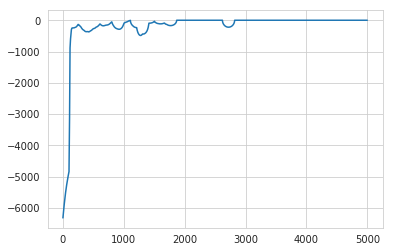

In [23]:
stat = data[0]
std_l = []
for t in range(len(stat[1])):
    std_l.append(-np.std(stat[1][max(0, t-100):min(len(stat[1]), t+100)]))
sns.lineplot(y=std_l, x=stat[0])

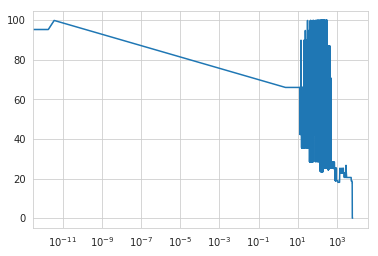

In [13]:
sns.lineplot(x=std_likelih2[:10000], y=accuracy2[:10000])
plt.xscale("log")
plt.savefig("acc_stdlike.pdf")

In [18]:
likelih = []
accuracy = []
time = []
accept = []
for i in data:
    likelih = likelih + i[1]
    accuracy = accuracy + i[2]
    time = time + i[0]

likelih = [int(x/100)*100 for x in likelih if x==x]
accuracy = [x for x in accuracy if x==x]
time = [x for x in time if x==x]

IndexError: list index out of range

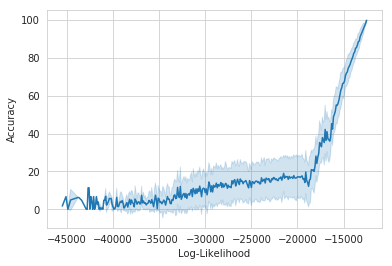

In [13]:
sns.lineplot(x=likelih, y=accuracy, ci= "sd", err_style = "band")
plt.xlabel("Log-Likelihood")
plt.ylabel("Accuracy")
plt.savefig("acc_like.pdf")
plt.show()

/home/shiyinw/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


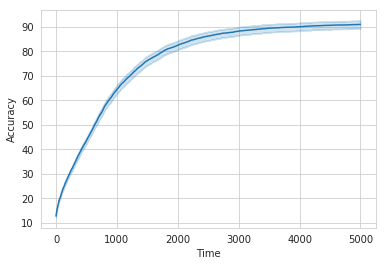

In [19]:
sns.lineplot(x=time, y=accuracy, err_style = "band")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.savefig("acc_time.pdf")
plt.show()

In [17]:
len(accuracy), len(accept)

(4168165, 4170166)

In [16]:
sns.lineplot(x=accept, y=accuracy, ci= "sd", err_style = "band")
plt.xlabel("Accepted")
plt.ylabel("Accuracy")
plt.savefig("acc_accept.pdf")
plt.show()

ValueError: arrays must all be same length

In [ ]:
fmri = sns.load_dataset("fmri")
fmri.head()

In [ ]:
ax = sns.lineplot(x=list(fmri["timepoint"]), y=list(fmri["signal"]))
# ax = sns.lineplot(x="timepoint", y="signal", hue="event", style="event", data=fmri)

In [24]:
random.random()

0.567050986702101